In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: Kumar Ankit
- PRN : 240840128022
- Date: 

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [4]:
###-----------------
### Import Libraries
###-----------------
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [5]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

TEST_SIZE = .2

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [6]:
###-----------------
### Hyper Parameters
###-----------------

EPOCHS = 60 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 64 # mini batch size (number of rows)

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [9]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [11]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [12]:
train_df.isna().sum().sum() # null value not a problem in images

0

In [13]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [14]:
def fn_plot_labels(train_df: pd.DataFrame, test_df: pd.DataFrame):
    ''' 
    Args:
        train_df : pd.DataFrame - Data for training
        test_df : pd.DataFrame - Data for validation
    Return:
        None
    '''

        # plotting class distribution of train set
    plt.subplot(1, 2, 1)
    ax = train_df['label'].value_counts().plot(kind = 'bar', title = 'Train Distribution',
                                              color = 'DarkBlue', alpha = .8)

    # plotting class distribution of valid set
    plt.subplot(1, 2, 2)
    ax = test_df['label'].value_counts().plot(kind = 'bar', title = 'valid Distribution',
                                              color = 'Orange', alpha = .8)

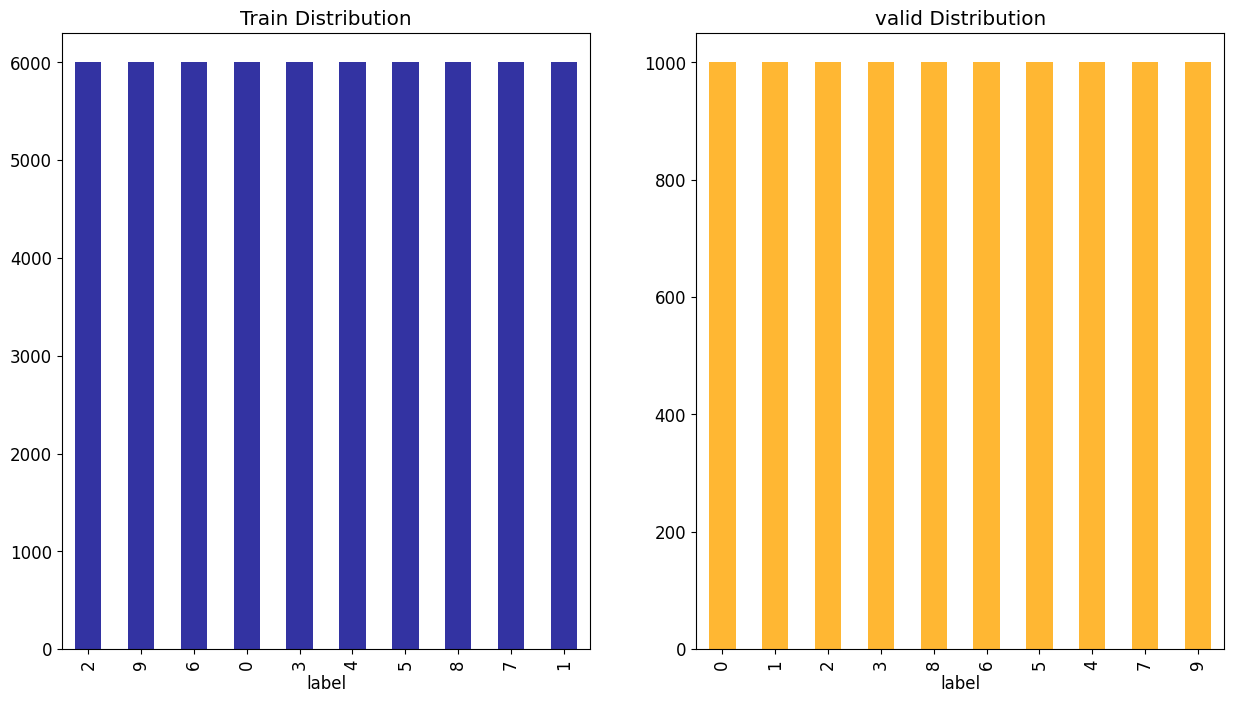

In [15]:
fn_plot_labels(train_df = train_df, test_df = test_df)

### converting into dataset

In [17]:
def split_features_labels(row):
    '''
    Args:
        row: array with 785 vaules 
    return: 
        features: np.array of shape 28 x 28 x 1
        label : integer
    '''
    # take values from index one onwards and reshape tham into image
    features = tf.reshape(row[1:], [28, 28, 1])
    # take first values of the rows as label
    labels = row[0]
    return features, labels

In [18]:
train_df.shape

(60000, 785)

In [19]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(split_features_labels)
train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(split_features_labels) # map is function of tensor flow which works like classic map functino
test_ds = test_ds.batch(BATCH_SIZE)



In [20]:
x = train_df

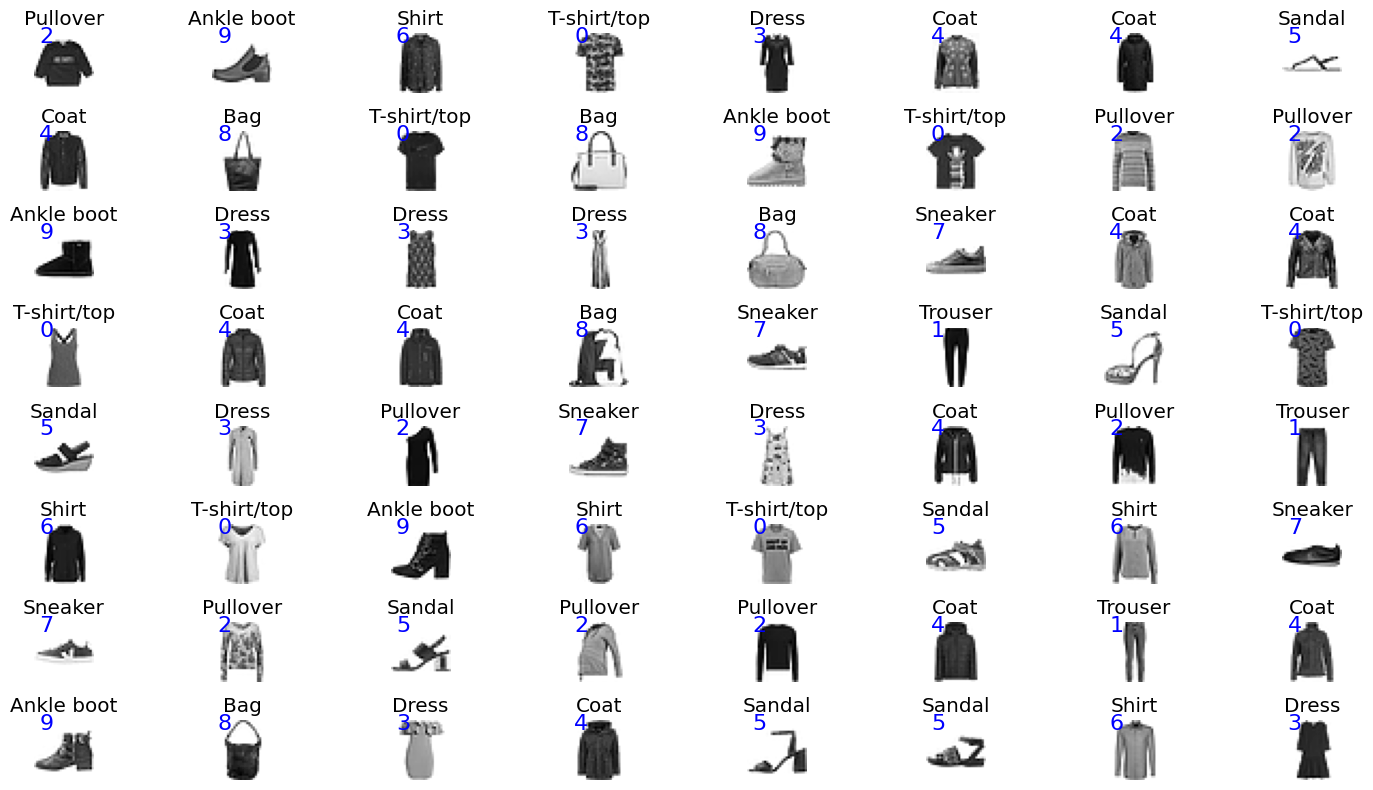

In [21]:
for images, labels in train_ds.take(1):

    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8 ,i+1)

        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)

        # add the class nameof the image in red text above the numeric label
        plt.title(class_names[labels[i].numpy()])

        # add the numeric label of the image in blue text at a specific position
        plt.text(2, 4, labels[i].numpy(), color = 'b', fontsize = 16)

        # switching off axis
        plt.axis('off')
    plt.tight_layout()
    #display the entire grid of image
    plt.show()


In [22]:
norm_layer = tf.keras.layers.Rescaling(1/255.)

img_batch, lbl_batch = next(iter(train_ds))
display(img_batch.shape, lbl_batch.shape)

norm_ds = train_ds.map(lambda x,y: (norm_layer(x), y))

img_batch, lbl_batch = next(iter(norm_ds))

display(img_batch[0].numpy().min(), img_batch[0].numpy().max())

del norm_ds

TensorShape([64, 28, 28, 1])

TensorShape([64])

0.0

1.0

### preprocessing and batching the data

In [24]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### convolution layer

<Axes: >

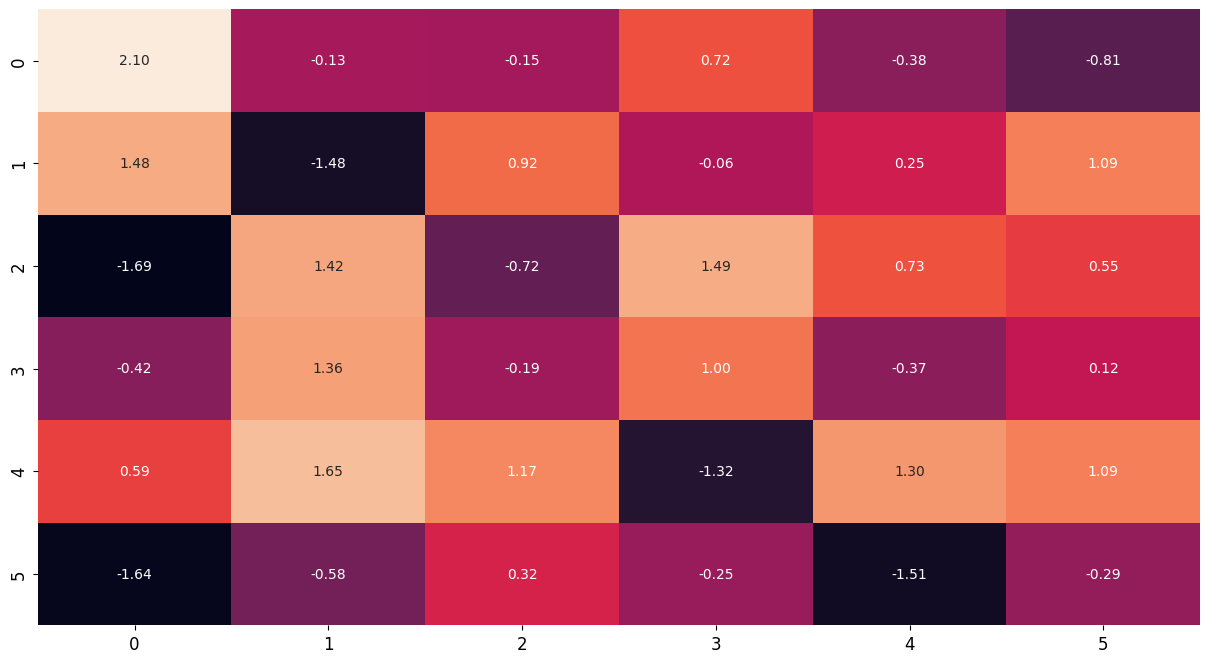

In [26]:
input_shape = (1, 6, 6, 1) # [batch, height, width, c]

X = tf.random.normal(input_shape)

sns.heatmap(X.numpy()[0, :, :, 0], annot = True, fmt = '.2f', cbar = False) # this is the resultant of our output layer after applying the connvolution applied to it

- tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

<Axes: >

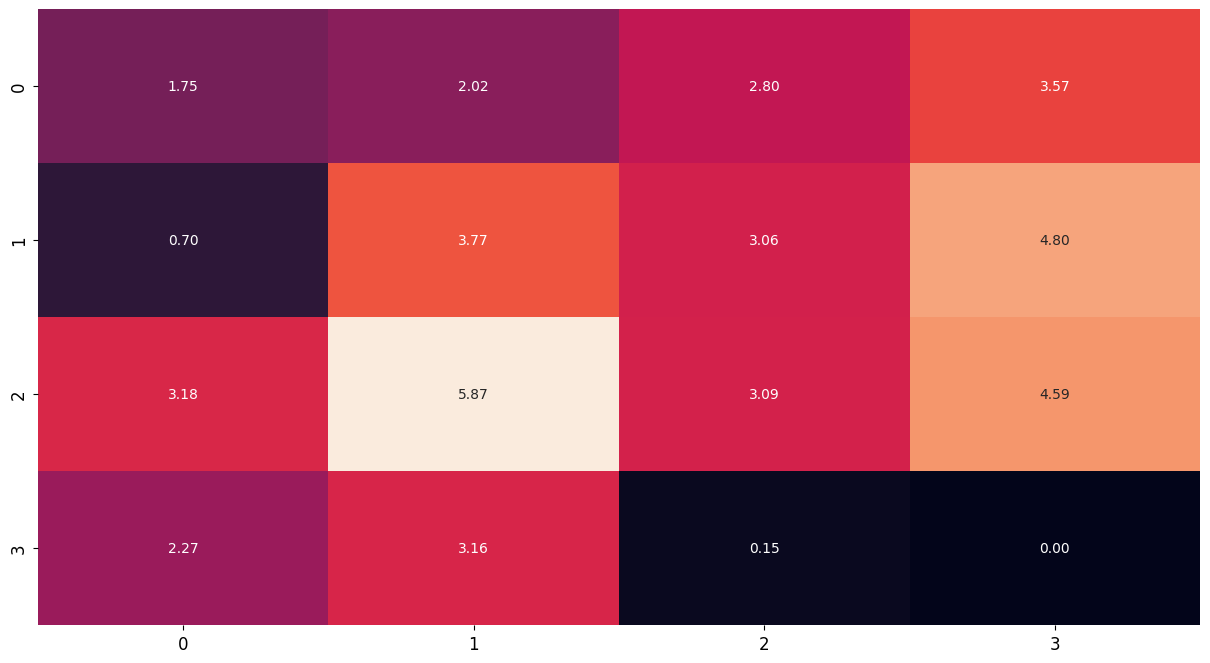

In [28]:
y = tf.keras.layers.Conv2D(1, #The number of filters (or output channels).
                           3, #The kernel size of a 3×3 filter
                   kernel_initializer = tf.constant_initializer(1.0),
                          use_bias = False,
                          activation = 'relu')(X)


sns.heatmap(y.numpy()[0, :, :, 0], annot = True, fmt = '.2f', cbar = False)

<Axes: >

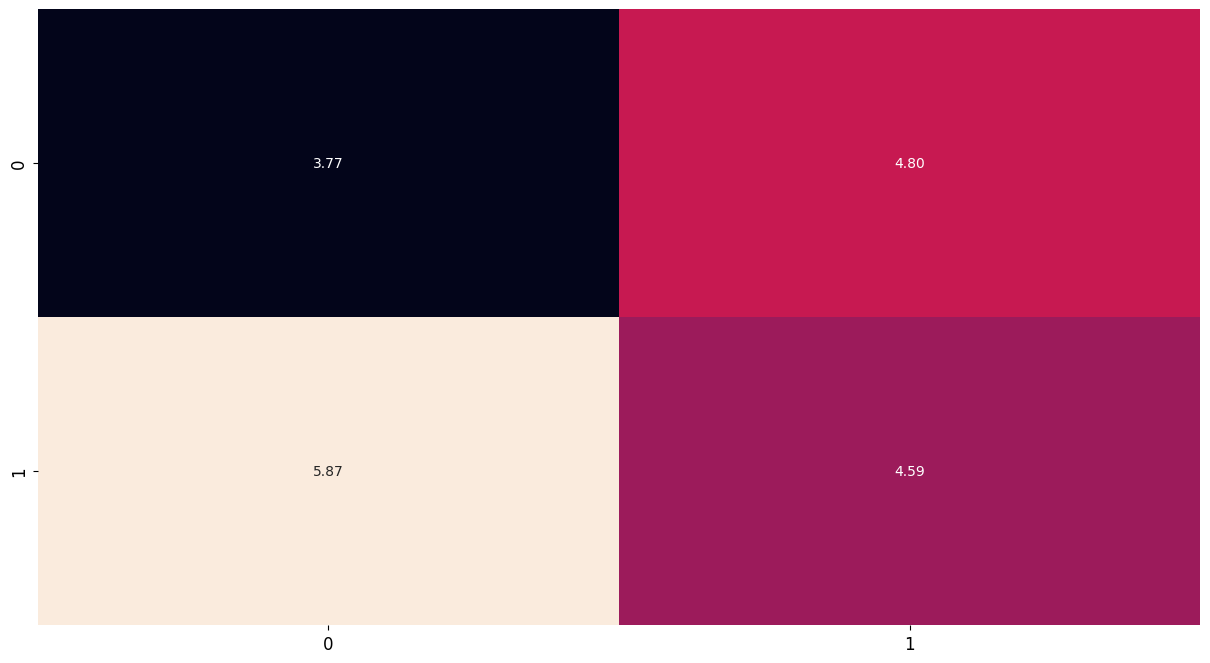

In [29]:
max_pool = tf.keras.layers.MaxPool2D(pool_size = (2 , 2), strides = (2, 2), padding = 'valid')

z = max_pool(y)

sns.heatmap(z.numpy()[0, :, :, 0], annot = True, fmt = '.2f', cbar = False)

In [30]:
krnl_initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

input_shape = (28, 28, 1)

inputs = tf.keras.Input(shape = input_shape, name = 'input')

x = tf.keras.layers.Rescaling(1./255.)(inputs)

# conv1

x = tf.keras.layers.Conv2D(32, (3,3),
                           kernel_initializer = krnl_initializer,
                           padding = 'same',
                           activation = tf.keras.activations.relu,
                           name = 'conv_1')(x)  # (28, 28, 32)
# max pool

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2), name = 'mp_1')(x) #( 14 x 14 x 32)

# conv2

x = tf.keras.layers.Conv2D(64, (3,3),
                           kernel_initializer = krnl_initializer,
                           padding = 'valid',
                           activation = tf.keras.activations.relu,
                           name = 'conv_2')(x)  # (12, 12, 64)
# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_2')(x) #( 6 x 6 x 64) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set3##
 # conv 3
x  = tf.keras.layers.Conv2D(128, (3,3), 
                            kernel_initializer = krnl_initializer,
                            activation = tf.keras.activations.relu,
                            name = 'conv_3')(x) # (4 x 4 x 128)


# flattning layer
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, name = 'fc_1', activation = tf.keras.activations.relu)(x)

outputs = tf.keras.layers.Dense(10, name = 'output')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'MNIST')

In [31]:
model.summary()

Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp_1 (MaxPooling2D)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp_2 (MaxPooling2D)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'])

In [48]:
history = model.fit(train_ds, validation_data= test_ds, epochs = EPOCHS, verbose = 2
                   )

Epoch 1/60
938/938 - 16s - 17ms/step - accuracy: 0.8334 - loss: 0.4579 - val_accuracy: 0.8705 - val_loss: 0.3477
Epoch 2/60
938/938 - 14s - 15ms/step - accuracy: 0.8957 - loss: 0.2886 - val_accuracy: 0.8988 - val_loss: 0.2749
Epoch 3/60
938/938 - 16s - 17ms/step - accuracy: 0.9114 - loss: 0.2438 - val_accuracy: 0.9134 - val_loss: 0.2426
Epoch 4/60
938/938 - 17s - 18ms/step - accuracy: 0.9225 - loss: 0.2111 - val_accuracy: 0.9183 - val_loss: 0.2284
Epoch 5/60
938/938 - 14s - 15ms/step - accuracy: 0.9330 - loss: 0.1831 - val_accuracy: 0.9213 - val_loss: 0.2208
Epoch 6/60
938/938 - 14s - 15ms/step - accuracy: 0.9412 - loss: 0.1591 - val_accuracy: 0.9242 - val_loss: 0.2203
Epoch 7/60
938/938 - 14s - 14ms/step - accuracy: 0.9502 - loss: 0.1370 - val_accuracy: 0.9218 - val_loss: 0.2363
Epoch 8/60
938/938 - 13s - 14ms/step - accuracy: 0.9571 - loss: 0.1178 - val_accuracy: 0.9194 - val_loss: 0.2520
Epoch 9/60
938/938 - 13s - 14ms/step - accuracy: 0.9620 - loss: 0.1005 - val_accuracy: 0.9161 - 

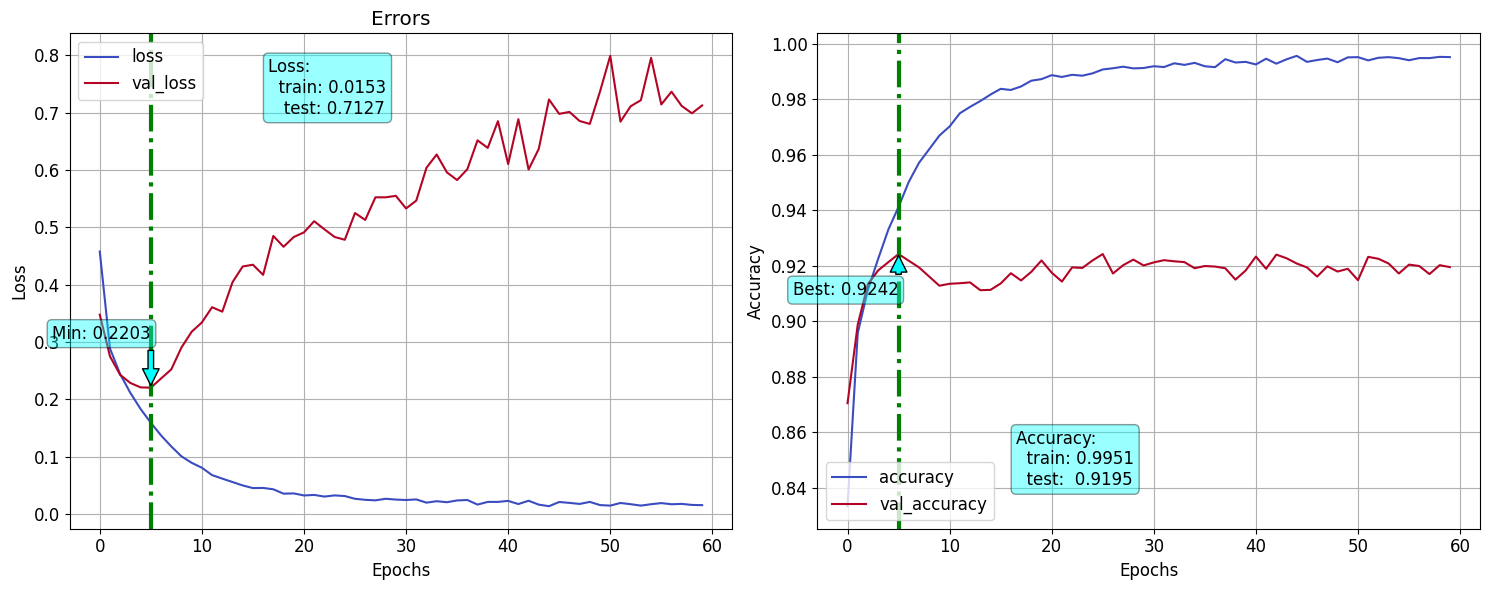

In [50]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [ ]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax() # new model (prediction only) = original model+ softmax
    ])

In [ ]:
prediction_model.summary()

In [ ]:
y_true, y_pred = [], []
for feat, lbls in train_ds:
    pred = prediction_model(feat).numpy()
    pred = pred.argmax(axis = 1)
    y_true.extend(lbls)
    y_pred.extend(pred)

len(y_true), len(y_pred)

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
y_true, y_pred = [], []
for feat, lbls in test_ds:
    pred = prediction_model(feat).numpy()
    pred = pred.argmax(axis = 1)
    y_true.extend(lbls)
    y_pred.extend(pred)

len(y_true), len(y_test)

In [ ]:
hist_df = pd.DataFrame(history.history)

In [ ]:
fn_plot_tf_hist(hist_df=hist_df)

In [ ]:
fn_plot_confusion_matrix(y_true, y_pred, labels= class_names)